# LASSI Data Analysis Pipeline V3

The latest version of our pipeline hides how the sausage is made.  Instead, for each scan, we simply call a high level function for the processing.  Since this code relies on GPU processing, each scan now only takes about 10 minutes to run.



## Summary

Our pipeline consists of these basic steps:

   * preliminary trimming and rotation of data from PTX file
   * smoothing of data in spherical coordinates
   * fitting each of the reference and signal scans to parabolas
   * regridding data to be in same reference frame
   * finding displacements in signal scan by finding residuals
   * fitting zernikes to this new surface
   * converting zernikes to the proper notation
   * sending zernikes to Active Surface manager
   
The current issues and problematic parts include:

   * smoothing step is still too slow - about 6 minutes per scan.
   * are we really achieving the desired accuracy?
   * we believe we are converting results correctly to zernike commands expected by Active Surface, but we really won't know till we try it

In [1]:
%matplotlib notebook

In [2]:
# This is the high level module that encapsulates the processing of a single scan
from lassiAnalysis import processLeicaScan


## Process Reference Scan

Processing PTX file ...
Elapsed minutes:  1.73
Smoothing data ...
system cmd:  runGpuSmooth /home/sandboxes/pmargani/LASSI/gpus/versions/gpu_smoothing /home/sandboxes/pmargani/LASSI/versions/lassi-analysis/data/Baseline_STA10_HIGH_METERS.ptx.csv Baseline_STA10_HIGH_METERS.ptx.csv 512 0.00100
Elapsed minutes:  5.88
Fitting paraboloa ...


<IPython.core.display.Javascript object>


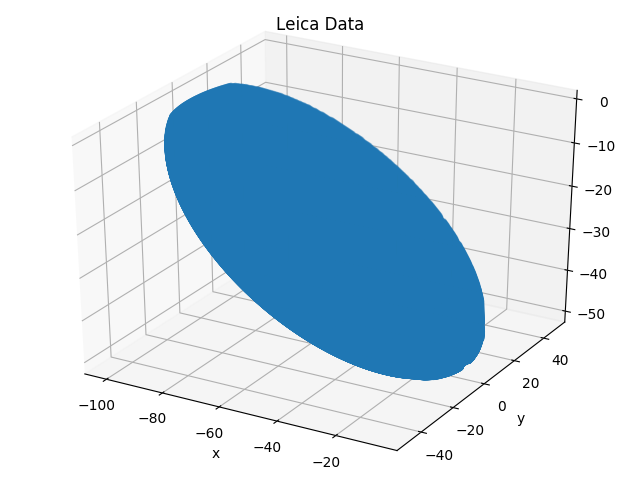

cleaned data fitted with coefficients:  [ 5.96133987e+01  7.85547036e-01 -2.35394334e+00 -4.92717171e+01
  2.01134971e-03 -4.37632738e-02]


<IPython.core.display.Javascript object>


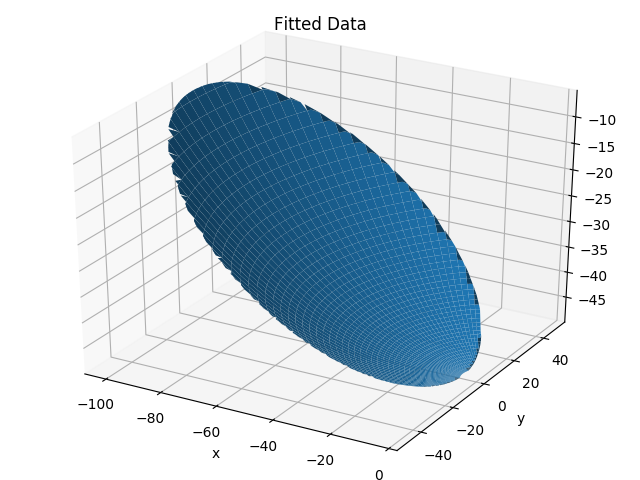

<IPython.core.display.Javascript object>


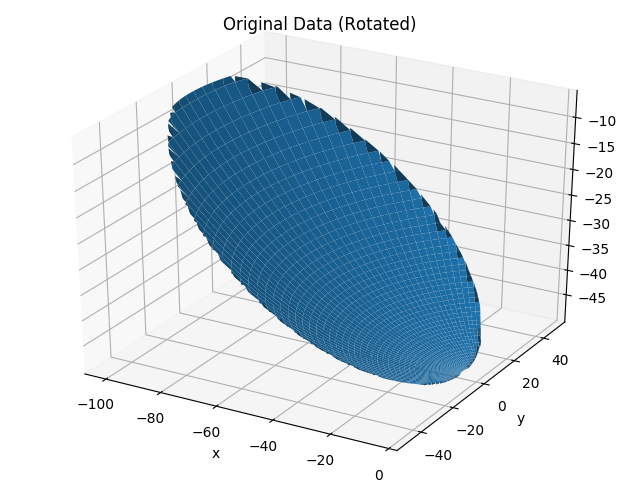

<IPython.core.display.Javascript object>


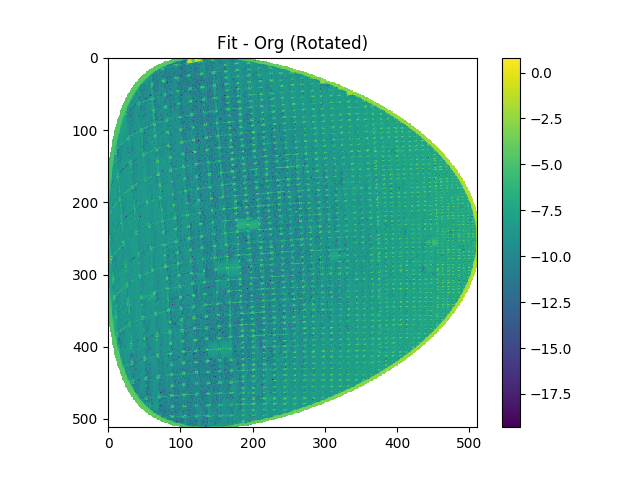

Elapsed minutes:  0.07
Regriding data ...
system cmd:  runGpuSmooth /home/sandboxes/pmargani/LASSI/gpus/versions/gpu_smoothing /home/sandboxes/pmargani/LASSI/versions/lassi-analysis/data/test test 512 0.10000 --no-cos
Elapsed minutes:  2.98
CPU times: user 1min 52s, sys: 31.5 s, total: 2min 24s
Wall time: 10min 39s


In [3]:
%%time
fpath = "data/Baseline_STA10_HIGH_METERS.ptx"
xRef, yRef, zRef = processLeicaScan(fpath)

## Process Signal Scan

Processing PTX file ...
Elapsed minutes:  1.66
Smoothing data ...
system cmd:  runGpuSmooth /home/sandboxes/pmargani/LASSI/gpus/versions/gpu_smoothing /home/sandboxes/pmargani/LASSI/versions/lassi-analysis/data/Test1_STA14_Bump1_High-02_METERS.ptx.csv Test1_STA14_Bump1_High-02_METERS.ptx.csv 512 0.00100
Elapsed minutes:  5.88
Fitting paraboloa ...


<IPython.core.display.Javascript object>


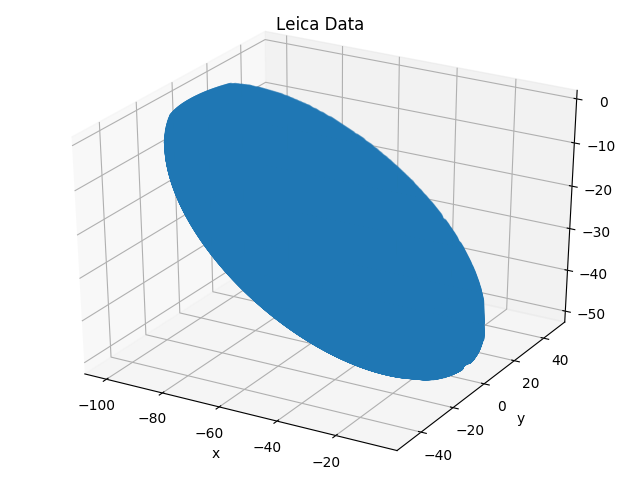

cleaned data fitted with coefficients:  [ 5.96084611e+01  7.86827696e-01 -2.34769628e+00 -4.92708138e+01
  1.91027495e-03 -4.37282254e-02]


<IPython.core.display.Javascript object>


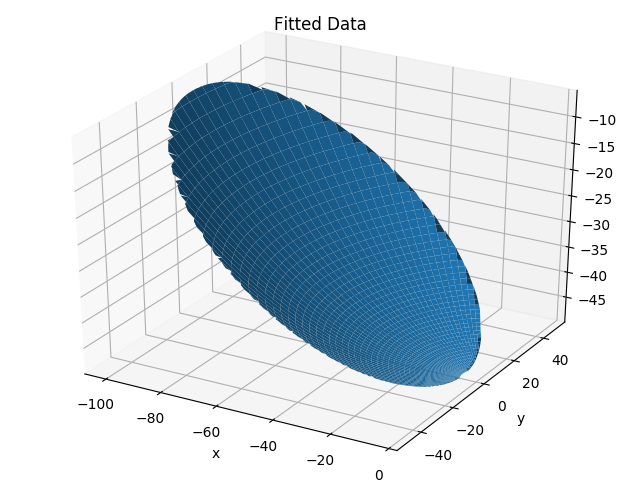

<IPython.core.display.Javascript object>


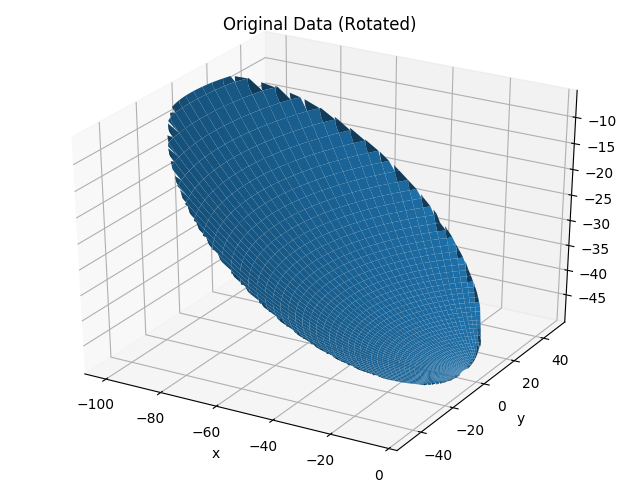

<IPython.core.display.Javascript object>


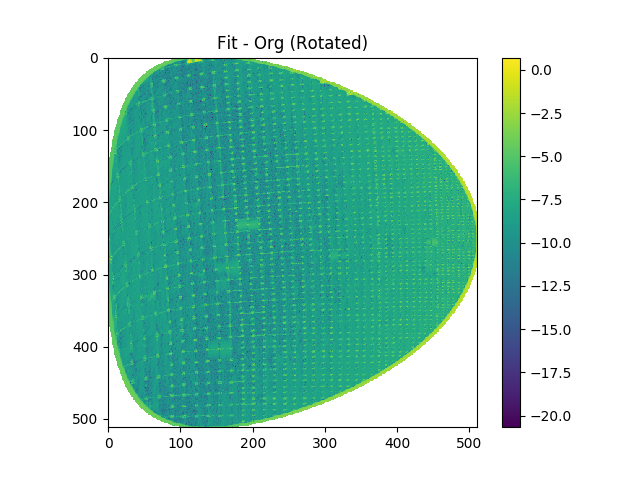

Elapsed minutes:  0.08
Regriding data ...
system cmd:  runGpuSmooth /home/sandboxes/pmargani/LASSI/gpus/versions/gpu_smoothing /home/sandboxes/pmargani/LASSI/versions/lassi-analysis/data/test test 512 0.10000 --no-cos
Elapsed minutes:  2.98
CPU times: user 1min 54s, sys: 39.4 s, total: 2min 33s
Wall time: 10min 35s


In [4]:
%%time
fpath = "data/Test1_STA14_Bump1_High-02_METERS.ptx"
xSig, ySig, zSig = processLeicaScan(fpath)

## Find the Deformations
Also known as, 'Show me the Bumps'.  This step is conceptually simple: we just find the difference between our reference and signal scan. 

<IPython.core.display.Javascript object>


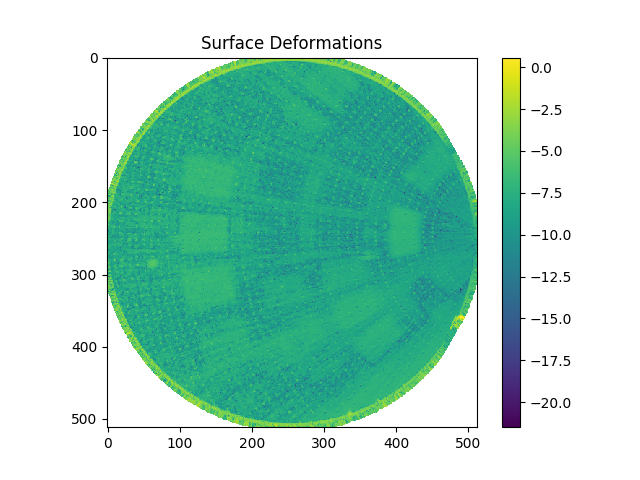

In [12]:
import numpy as np
from parabolas import imagePlot
diffData = zRef - zSig
N = 512
diffData.shape = (N, N)
diffDataLog = np.log(np.abs(diffData))
imagePlot(diffDataLog, "Surface Deformations")

## Fit Zernikes to this surface
This is identical to what we did in the first version of our pipeline.  But note, that we're still not sure that we want to do this on this data: we probably need put this image on a unit circle?

<font color='red'>TODO:</font> Determine what else might need to be done to image before fitting zernikes.

<IPython.core.display.Javascript object>


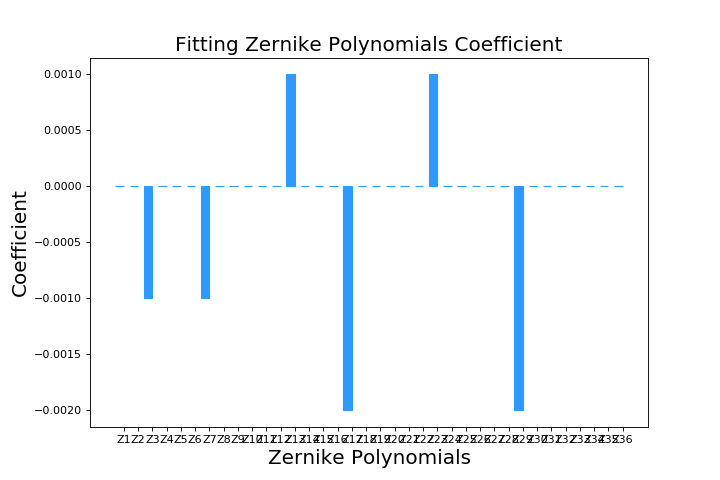

<IPython.core.display.Javascript object>


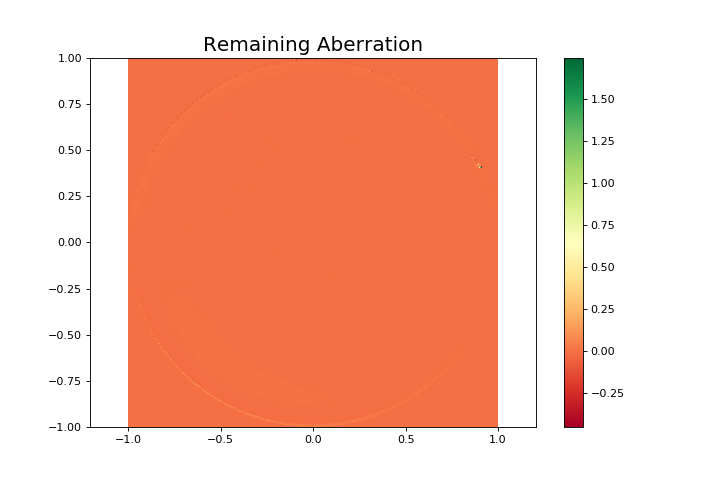

                            Zernike Polynomials List                              
----------------------------------------------------------------------------------
|   Z1  |   Z2  |   Z3  |   Z4  |   Z5  |   Z6  |   Z7  |   Z8  |   Z9  |  Z10  |
----------------------------------------------------------------------------------
| 0.000 |-0.000 |-0.001 | 0.000 | 0.000 |-0.000 |-0.001 | 0.000 | 0.000 | 0.000 |
----------------------------------------------------------------------------------
|  Z11  |  Z12  |  Z13  |  Z14  |  Z15  |  Z16  |  Z17  |  Z18  |  Z19  |  Z20  |
----------------------------------------------------------------------------------
| 0.000 |-0.000 | 0.001 | 0.000 | 0.000 | 0.000 |-0.002 | 0.000 | 0.000 |-0.000 |
----------------------------------------------------------------------------------
|  Z21  |  Z22  |  Z23  |  Z24  |  Z25  |  Z26  |  Z27  |  Z28  |  Z29  |  Z30  |
----------------------------------------------------------------------------------
| 0.000 |

<IPython.core.display.Javascript object>


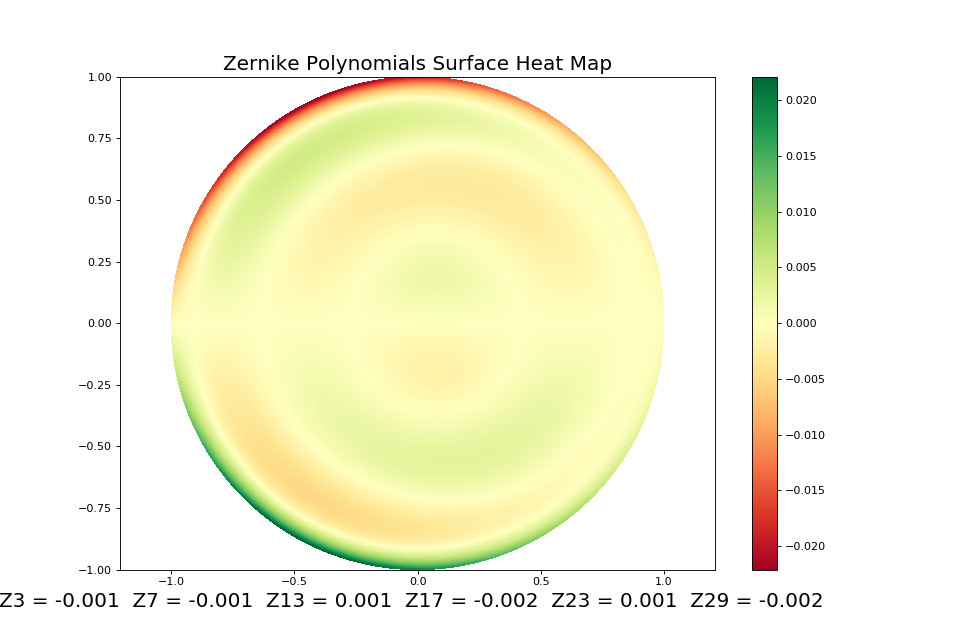

Z3 =  -0.001 Z11 y Tilt
Z7 =  -0.001 Z31 Primary y Coma
Z13 =  0.001 Z42 Secondary Astigmatism at 45
Z17 =  -0.002 Z51 Secondary y Coma
Z23 =  0.001 Z62 Tertiary Astigmatism at 45
Z29 =  -0.002 Z71 Tertiary y Coma


In [16]:
import opticspy
from copy import copy
import numpy as np

# replace NaNs with zeros
diffDataOrg = copy(diffData)
diffData[np.isnan(diffData)] = 0.

# find the first 12 Zernike terms
numZsFit = 36
fitlist,C1 = opticspy.zernike.fitting(diffData,
                                      numZsFit,
                                      remain2D=1,
                                      barchart=1)
print "fitlist: ", fitlist
C1.listcoefficient()
C1.zernikemap()

## Convert the coefficients from Noll to ANSI
Recall that opticspy works in Noll notation, while the Active Surface Manager seems to work in a modified version of ANSI (offset by one, phase rotated by 90 degrees).
Whether this is the only conversion needed to be done is another remaining open question.

In [17]:
from zernikeIndexing import noll2asAnsi, printZs
# why does the fitlist start with a zero? for Z0??  Anyways, avoid it
nollZs = fitlist[1:(numZsFit+1)]
asAnsiZs = noll2asAnsi(nollZs)
print "nolZs"
printZs(nollZs)
print "active surface Zs"
printZs(asAnsiZs)

nolZs
[0]
[-0.0, -0.001]
[0.0, 0.0, -0.0]
[-0.001, 0.0, 0.0, 0.0]
[0.0, -0.0, 0.001, 0.0, 0.0]
[0.0, -0.002, 0.0, 0.0, -0.0, 0.0]
[0.0, 0.001, -0.0, 0.0, 0.0, 0.0, -0.0]
[-0.002, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0]
active surface Zs
[0]
[-0.0, -0.001]
[-0.0, 0.0, 0.0]
[0.0, 0.0, -0.001, 0.0]
[0.0, -0.0, 0.0, 0.001, 0.0]
[-0.0, 0.0, 0.0, -0.002, 0.0, 0.0]
[0.0, 0.0, -0.0, 0.0, 0.001, 0.0, 0.0]
[-0.0, -0.0, 0.0, 0.0, -0.002, 0.0, 0.0, 0.0]


## Send these Coefficients to the Active Surface Manager

The Active Surface Manager has the zernike_coeff parameter (indexes 1 through N).  When these are set, the manager can use them to compute the displacement of each individual actuator.

However, one has to have everything setup correctly and have the right permissions, so we won't simply call it from here.  Instead, here's the instructions:
   * save asAnsiZs to numpy file
   * decide which telescope you want to use (real, sim?)
   * use the new ActiveSurfaceDevice.py here: /home/sandboxes/pmargani/sparrow/master3/sparrow/gbt/api/ygor/src
   * python ActiveSurfaceDevice.py <path to numpy file>

## Conclusions
If we look at the results we got, how do they compare to what the active surface was really commanded to during it's bump scan?

<IPython.core.display.Javascript object>


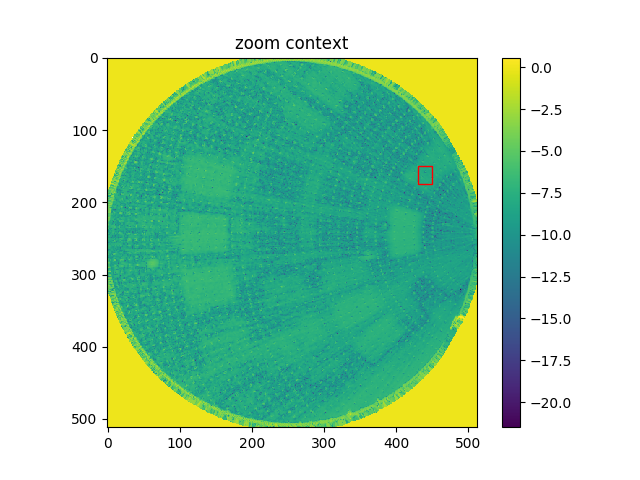

<IPython.core.display.Javascript object>


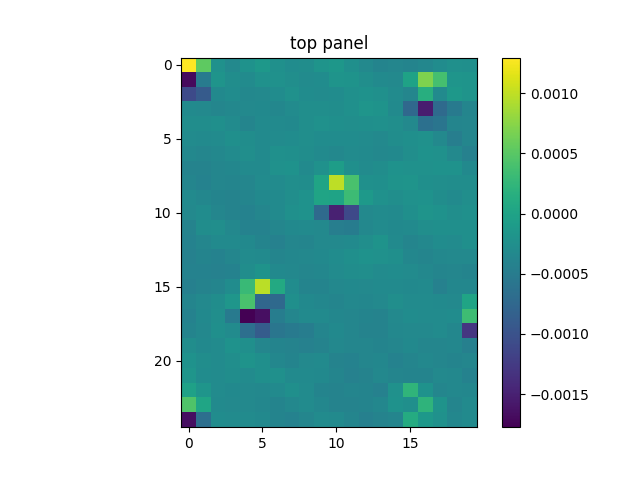

<IPython.core.display.Javascript object>


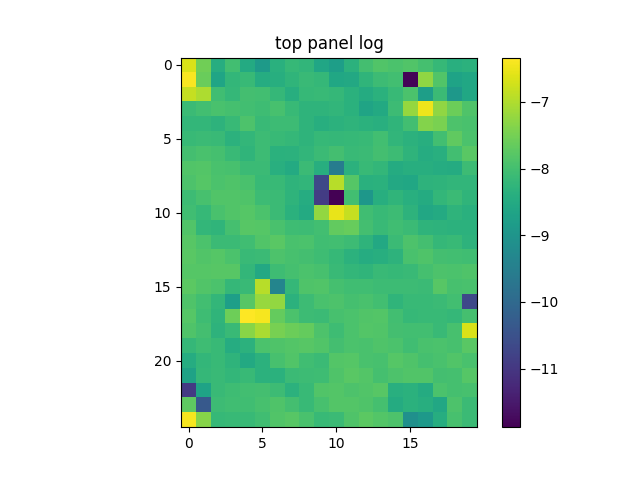

<IPython.core.display.Javascript object>


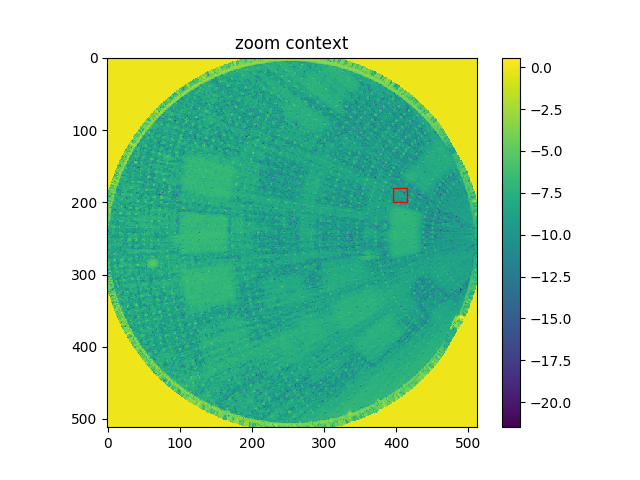

<IPython.core.display.Javascript object>


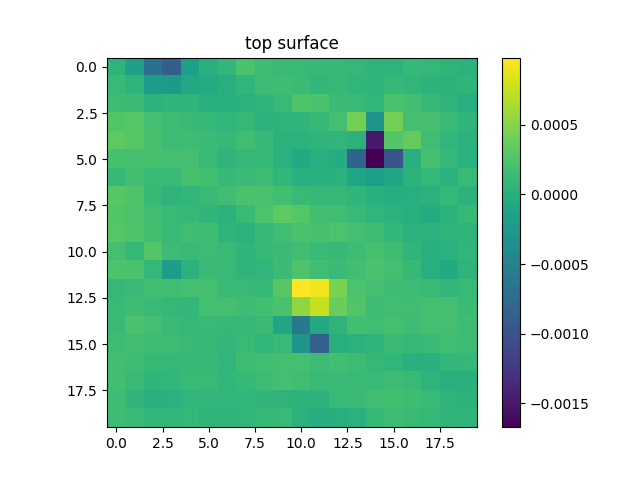

<IPython.core.display.Javascript object>


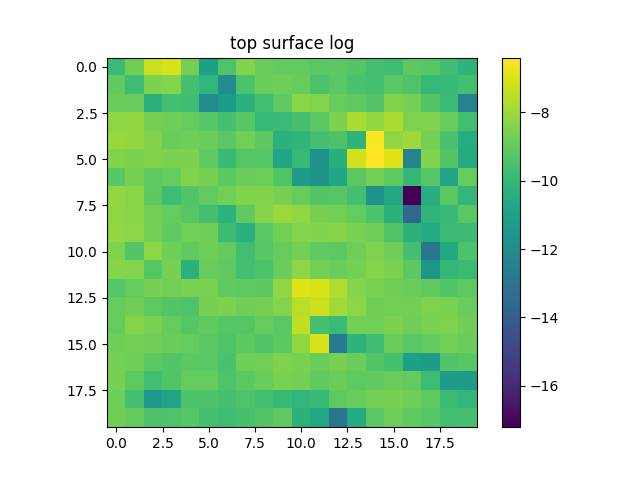

<IPython.core.display.Javascript object>


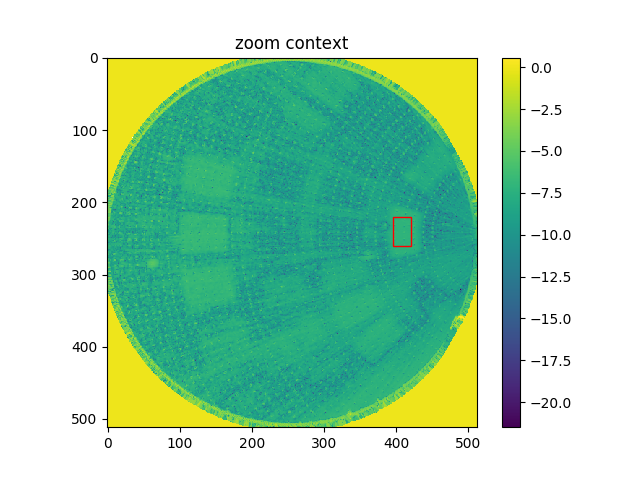

<IPython.core.display.Javascript object>


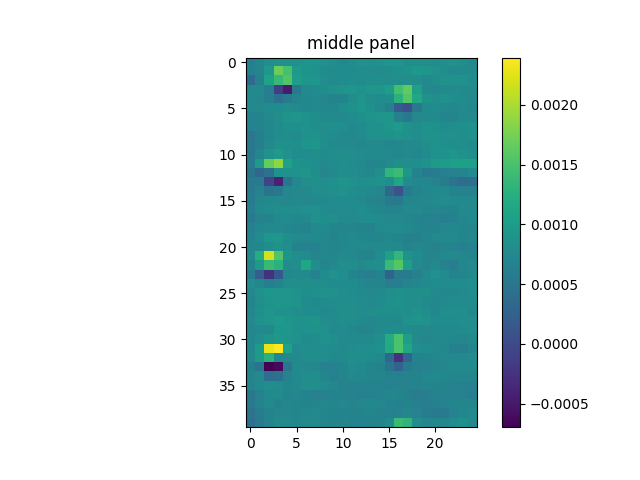

<IPython.core.display.Javascript object>


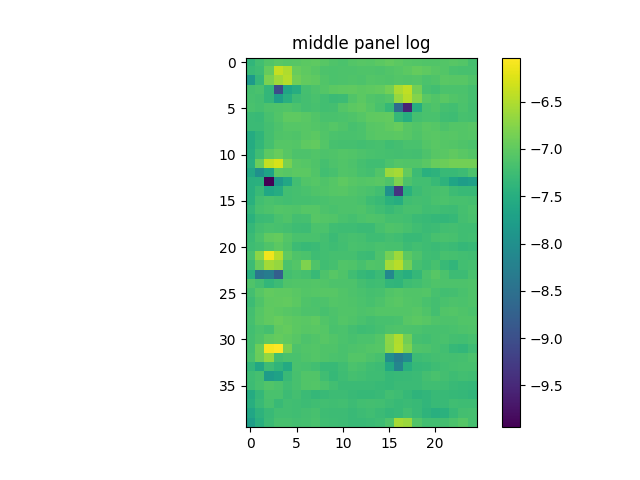

<IPython.core.display.Javascript object>


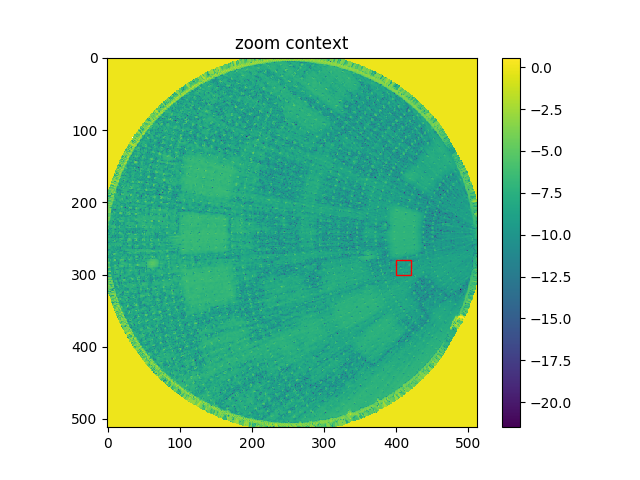

<IPython.core.display.Javascript object>


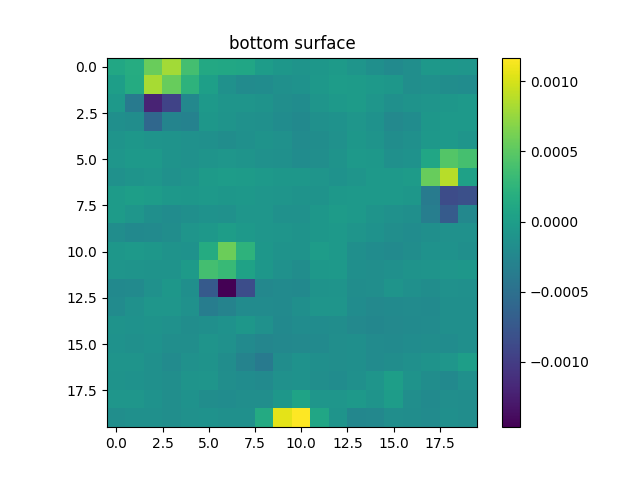

<IPython.core.display.Javascript object>


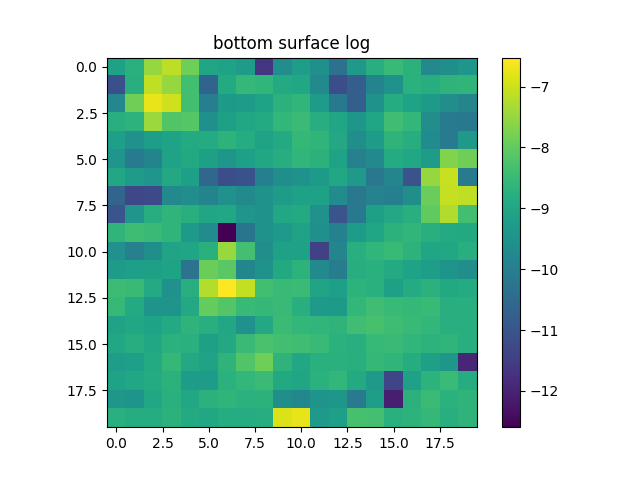

<IPython.core.display.Javascript object>


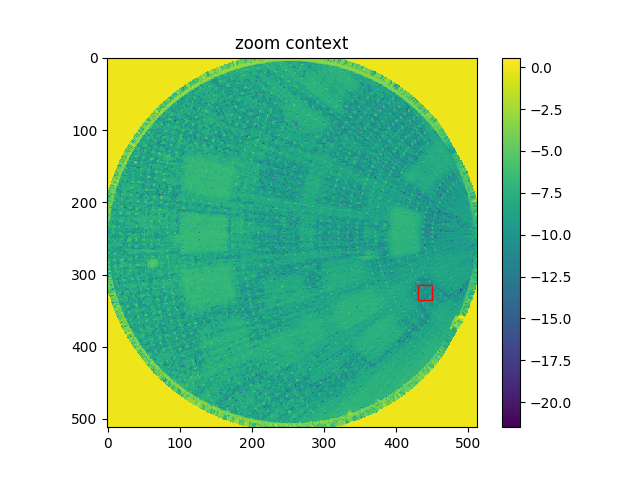

<IPython.core.display.Javascript object>


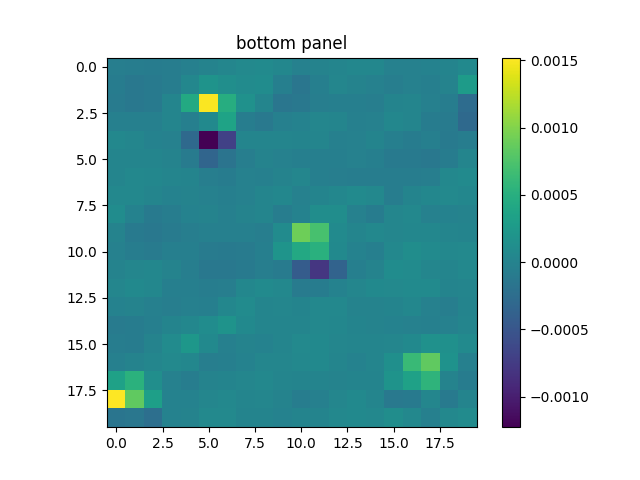

<IPython.core.display.Javascript object>


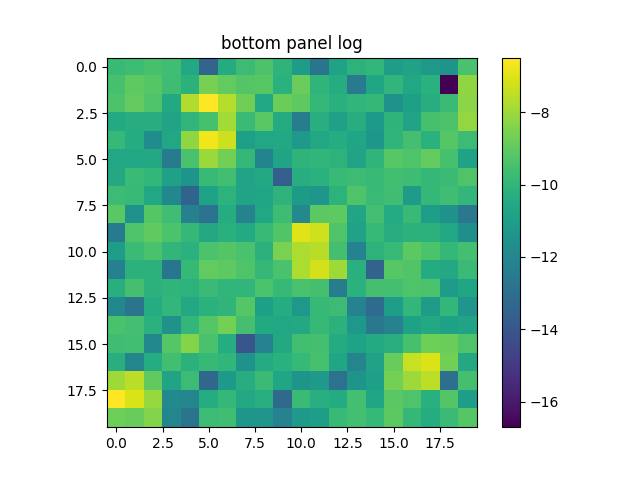

<IPython.core.display.Javascript object>


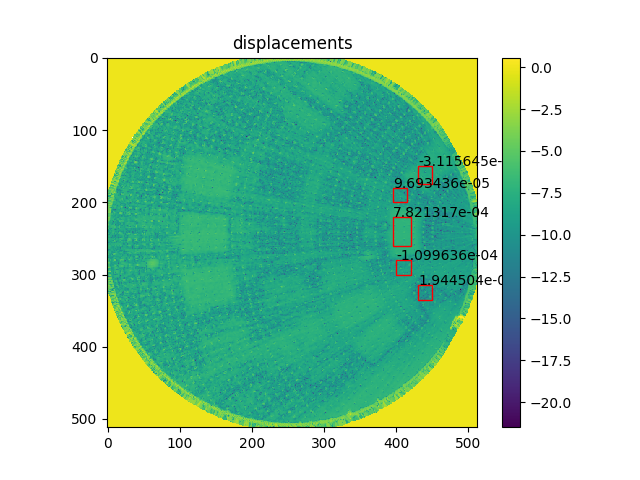

top panel: mean=-3.115645e-04 std=2.442603e-04 N=5.000000e+02 stdN=1.092365e-05
top surface: mean=9.693436e-05 std=2.007148e-04 N=4.000000e+02 stdN=1.003574e-05
middle panel: mean=7.821317e-04 std=2.057897e-04 N=1.000000e+03 stdN=6.507642e-06
bottom surface: mean=-1.099636e-04 std=2.097912e-04 N=4.000000e+02 stdN=1.048956e-05
bottom panel: mean=1.944504e-05 std=1.900947e-04 N=4.000000e+02 stdN=9.504734e-06
top panel: disp(microm)=4.084988e+02 stdN=1.483382e+01
middle panel: disp(microm)=-6.851974e+02 stdN=1.196100e+01
bottom panel: disp(microm)=-1.294087e+02 stdN=1.415524e+01


In [18]:
from surfaceZoom import *
calculateVertexDisplacements(diffData, diffDataLog)

Here's our expected results with the analysis from version 2 of our pipeline:
![summary](bumpComparison.png)